# Group Details
## Group Name:
### Student 1:
### Student 2:
### Student 3:

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
# Check if CUDA is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [4]:
TRAIN = True
GRID_SEARCH = False

In [5]:
def load_trajectory(filename, task):
    """
    This function loads a trajectory from a given file and returns the trajectory and energy data. 
    If the task is 'task_3', it also returns the framework data.

    Parameters:
    filename (str): The name of the file from which to load the trajectory.
    task (str): The task for which the trajectory is being loaded. 
                This should be one of 'task_1', 'task_2', or 'task_3'.

    Returns:
    tuple: Depending on the task, the function returns:
           - (trajectory, energy) for 'task_1' and 'task_2'
           - (trajectory, framework, energy) for 'task_3'
    """
    traj = np.load(filename)
    if task == 'task_1' or task == 'task_2':
        trajectory = traj['trajectory']
        energy = traj['energy']
        return trajectory, energy
    if task == 'task_3':
        trajectory = traj['trajectory']
        framework = traj['framework']
        energy = traj['energy']
        return trajectory, framework, energy

Below, you can find an example of how to load a trajectory. ```trajectory``` contains the particle position, velocity and charge data. ```energy``` contains the energy of the system at various timesteps. The shape of the arrays is as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

In [6]:
trajectory, energy = load_trajectory('data/task1_2/train/trajectory_0.npz', 'task_1')
print(f'Trajectory shape: {trajectory.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Energy shape: (40, 1)


In [7]:
x_0 = trajectory[0][0][0]
y_0 = trajectory[0][0][1]
print(f'Initial position: {x_0}, {y_0} Blue')

Initial position: 9.595544088638388, 7.531951993028981 Blue


The following code provides an example of how to visualize a trajectory. Feel free to modify this code, or write your own function. When evaluating your model in task 2 and 3, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

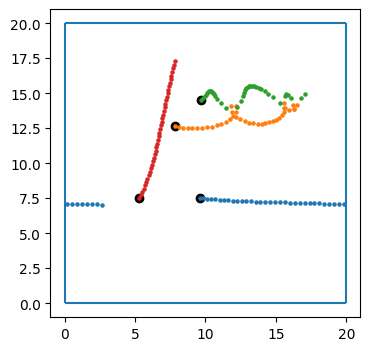

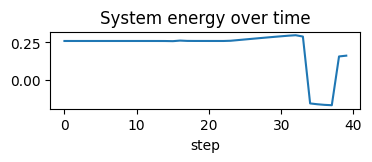

In [8]:
def plot_trajectory_energy(trajectory, energy):
    """
    This function plots the trajectory of a system and its energy over time.

    Parameters:
    trajectory (numpy.ndarray): A 2D array representing the trajectory of the system. 
                                The first dimension represents time, and the second dimension represents the x and y coordinates.
    energy (numpy.ndarray): A 1D array representing the energy of the system at each time step.

    The function first plots the trajectory on a 2D grid, with the x and y coordinates on the x and y axes respectively. 
    The initial position is marked in black. The trajectory is represented by a scatter plot, with each point representing the position at a different time step.

    Then, the function plots the energy of the system over time on a separate graph. The x-axis represents the time step, and the y-axis represents the energy.
    """
    x = trajectory[...,0]
    y = trajectory[...,1]

    plt.figure(figsize=(4,4))
    plt.vlines([0,20],0,20)
    plt.hlines([0,20],0,20)

    plt.scatter(x[0], y[0], c='black')

    for i in range(x.shape[1]):
        plt.scatter(x[:,i], y[:,i], s=5)

    plt.xlim(-1,21)
    plt.ylim(-1,21)

    plt.show()
    plt.figure(figsize=(4,1))
    plt.plot(energy)
    plt.xlabel('step')
    plt.title('System energy over time')
    plt.show();

plot_trajectory_energy(trajectory, energy)

# Task 1

Implement task 1 below. Feel free to add extra code cells for different components of your implementation.

## Data Processing

In [9]:
def minimum_image_distance(pos1, pos2, box_length):
    """
    Compute the distance between two points with the minimum image convention.

    Parameters:
    pos1, pos2: numpy arrays representing the positions of the two points.
    box_length: float representing the length of one side of the box.

    Returns:
    float representing the distance between the two points.
    """
    delta = pos2 - pos1
    delta = delta - box_length * np.round(delta / box_length)
    return np.sqrt(np.sum(delta**2))

In [10]:
from torch_geometric.data import Data

def create_graph_from_particles(particles, energy, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a graph representation of a system of particles for use in graph neural networks. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    particles (numpy.ndarray): A 2D array representing the particles in the system. 
                               Each row represents a particle, with the first two columns representing the x and y coordinates of the particle, 
                               and the remaining columns representing additional features of the particle.
    energy (float): The energy of the system.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    torch_geometric.data.Data: A Data object representing the graph. 
                               The node features, edge indices, edge attributes, and energy are stored as attributes of this object.

    The function first creates a list of node features and a list of edge indices and attributes. 
    Then, it converts these lists into PyTorch tensors and creates a Data object from them. 
    Finally, it validates the Data object to ensure that it is correctly formatted.
    """
    num_particles = particles.shape[0]
    x = particles[:, 2:] # Position is not used as node feature

    edge_index = []
    edge_attr = []
    for i in range(num_particles):
        for j in range(num_particles):
            if i != j:  # Avoid self-loops

                # Append edge if distance is below cutoff
                pos1 = particles[i, :2]
                pos2 = particles[j, :2]
                distance = minimum_image_distance(pos1, pos2, box_length)
                
                edge_index.append([i, j])
                if distance < cutoff_value: # TODO Per essere corretto non bisognerebbe creare l'edge se la distanza è maggiore del cutoff, ma facendo cosi ci sono errori in alcuni casi limite (annuncio canvas). Ho messo quindi rami con pesi negativi (distanze) per gli edge che non dovrebbero esistere. In questo modo il modello dovrebbe imparare a non considerarli.
                    edge_attr.append(distance)
                else:
                    edge_attr.append(-1.0) # Use -1.0 as padding value

    x = torch.tensor(x, dtype=torch.float)         
    edge_index = torch.tensor(edge_index).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    energy = torch.tensor(energy, dtype=torch.float)

    # Create Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=energy)

    # Validate data object
    data.validate(raise_on_error=True)
    
    return data


def create_particle_data_list(trajectory, energies, box_length=20.0, cutoff_value=10.0):
    """
    This function creates a list of graph representations of a system of particles for each time step in a trajectory. 
    Each particle is represented as a node in the graph, and edges are created between particles that are within a certain cutoff distance of each other.

    Parameters:
    trajectory (numpy.ndarray): A 3D array representing the trajectory of the system. 
                                The first dimension represents time, the second dimension represents particles, 
                                and the third dimension represents the x and y coordinates of the particles.
    energies (numpy.ndarray): A 1D array representing the energy of the system at each time step.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.0.
    cutoff_value (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.

    Returns:
    list: A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.

    The function iterates over each time step in the trajectory, creating a graph for each one and appending it to the list. 
    The graphs are created using the create_graph_from_particles function.
    """
    particle_data_list = []
    for i in range(trajectory.shape[0]):
        particles = trajectory[i]
        energy = energies[i]
        particle_data_list.append(create_graph_from_particles(particles, energy, box_length, cutoff_value))
    return particle_data_list

particle_data_list = create_particle_data_list(trajectory, energy)
particles = trajectory[0]
particles_graph = particle_data_list[0]
print(f'Particles ({particles.shape}):\n {particles}')
print(f'Particles graph:\n {particles_graph}')

Particles ((4, 5)):
 [[ 9.59554409  7.53195199  0.51611651 -0.06928145 -1.        ]
 [ 7.84276225 12.65405926  0.5342578  -0.12193773  1.        ]
 [ 9.71213475 14.49577317  0.28795482  0.33377239 -1.        ]
 [ 5.2803654   7.53604669  0.25443658  0.42087594 -1.        ]]
Particles graph:
 Data(x=[4, 3], edge_index=[2, 12], edge_attr=[12], y=[1])


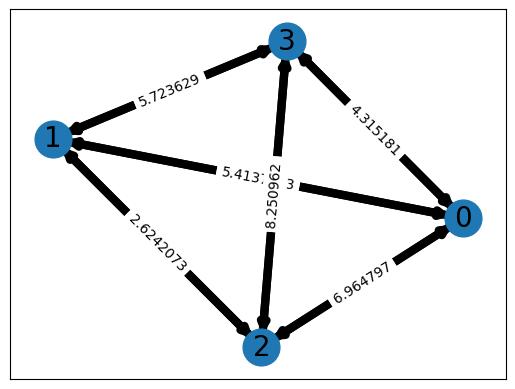

In [11]:
import networkx as nx

def visualize_graph(data):
    """
    This function visualizes a graph represented by a PyTorch Geometric Data object using NetworkX and Matplotlib.

    Parameters:
    data (torch_geometric.data.Data): A Data object representing the graph. 
                                      The node features, edge indices, and edge attributes are stored as attributes of this object.

    The function first creates a NetworkX DiGraph object and adds nodes and edges to it based on the edge indices and edge attributes in the Data object. 
    The edges are weighted based on the edge attributes.

    Then, the function uses NetworkX's spring layout algorithm to calculate the positions of the nodes, and draws the nodes, edges, and labels using Matplotlib.

    Finally, the function displays the graph using Matplotlib's pyplot.show() function.
    """
    edge_index = data.edge_index.cpu().numpy()
    edge_attr = data.edge_attr.cpu().numpy() 
    num_nodes = data.x.shape[0]

    # Create a networkx graph
    G = nx.DiGraph()

    # Add nodes
    for i in range(num_nodes):
        G.add_node(i)

    # Add edges with weights
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        weight = edge_attr[i] 
        G.add_edge(src, dst, weight=weight)

    # Draw the graph
    pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(G, pos, width=6)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

    # edge labels
    edge_labels = dict([((u, v,), d['weight'])
                        for u, v, d in G.edges(data=True)])
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.axis('on')
    plt.show()

visualize_graph(particles_graph)

In [12]:
# Compute distances between all pairs of nodes
def compute_distances(particles, box_length=20):
    """
    This function computes the distances between all pairs of particles in a system, taking into account the periodic boundary conditions of the system.

    Parameters:
    particles (numpy.ndarray): A 2D array representing the particles in the system. 
                               Each row represents a particle, with the first two columns representing the x and y coordinates of the particle.
    box_length (float, optional): The length of the box in which the particles are contained. 
                                  This is used to calculate the minimum image distance between particles. Defaults to 20.

    Returns:
    numpy.ndarray: A 2D array representing the distance between each pair of particles. 
                   The element at the i-th row and j-th column represents the distance between the i-th and j-th particles.

    The function first initializes a 2D array of zeros with a size equal to the number of particles. 
    Then, it iterates over each pair of particles, calculates the minimum image distance between them, 
    and stores the result in the corresponding element of the distance array. 
    Since the distance between the i-th and j-th particles is the same as the distance between the j-th and i-th particles, 
    the function only calculates the distance once for each pair of particles.
    """
    num_particles = len(particles)
    distances = np.zeros((num_particles, num_particles))

    for i in range(num_particles):
        pos_1 = particles[i, :2]
        for j in range(i+1, num_particles):
            pos_2 = particles[j, :2]
            distances[i, j] = minimum_image_distance(pos_1, pos_2, box_length)
            distances[j, i] = distances[i, j]  # The distance matrix is symmetric

    return distances

particles = trajectory[0]
distances = compute_distances(particles)
distances


array([[0.        , 5.41370733, 6.96479711, 4.31518063],
       [5.41370733, 0.        , 2.62420725, 5.72362912],
       [6.96479711, 2.62420725, 0.        , 8.2509619 ],
       [4.31518063, 5.72362912, 8.2509619 , 0.        ]])

In [13]:
from torch.utils.data import Dataset

class ParticleDataset(Dataset):
    """
    A PyTorch Dataset for representing a system of particles. 
    The dataset is created from a list of file paths, each of which contains a trajectory of the system.

    Attributes:
    file_paths (list): A list of file paths from which to load the trajectories.
    task (str): The task for which the dataset is being created. This should be one of 'task_1', 'task_2', or 'task_3'.
    max_len (int): The maximum number of particles in the system.
    box_length (float, optional): The length of the box in which the particles are contained. Defaults to 20.0.
    cutoff (float, optional): The maximum distance at which two particles are considered to be connected by an edge. Defaults to 10.0.
    data_list (list): A list of PyTorch Geometric Data objects, each representing the graph of the system at a different time step.
    """
    def __init__(self, file_paths, task, max_len, box_length=20.0, cutoff=10.0):
        """
        Initializes the ParticleDataset with the given file paths, task, maximum number of particles, box length, and cutoff distance.
        """
        self.file_paths = file_paths
        self.task = task
        self.max_len = max_len
        self.box_length = box_length
        self.cutoff = cutoff
        self.data_list = []
        for file_path in tqdm(file_paths):
            if task == 'task_1' or task == 'task_2':
                trajectory, energy = load_trajectory(file_path, task)
                particle_data_list = create_particle_data_list(trajectory, energy, self.box_length, self.cutoff)
            elif task == 'task_3':
                trajectory, framework, energy = load_trajectory(file_path, task)
                particle_data_list = create_particle_data_list(trajectory, energy, self.box_length, self.cutoff)
            self.data_list += particle_data_list
    
    def __len__(self):
        """
        Returns the length of the dataset, i.e., the number of time steps in all trajectories.
        """
        return len(self.data_list)
    
    def __getitem__(self, idx):
        """
        Returns the Data object at the given index.
        """
        return self.data_list[idx]
    


In [14]:
from sklearn.model_selection import train_test_split
import glob

# Define the paths and parameters
file_paths = glob.glob('data/task1_2/train/*.npz')

max_len = 40  # The maximum length of the trajectories is 40
box_length = 20.0  # The length of the simulation box
cutoff = 10.0  # The cutoff distance for the edges
task = 'task_1'  # The task to perform
batch_size = 1  # The batch size

train_file_paths, val_file_paths = train_test_split(file_paths, test_size=0.2, random_state=0)

# Create datasets
train_dataset = ParticleDataset(train_file_paths, task, max_len, box_length, cutoff)
val_dataset = ParticleDataset(val_file_paths, task, max_len, box_length, cutoff)

print(f'Train dataset: {len(train_dataset)} samples')
print(f'Validation dataset: {len(val_dataset)} samples')

100%|██████████| 180/180 [00:01<00:00, 157.17it/s]

Train dataset: 28800 samples
Validation dataset: 7200 samples


In [15]:
train_dataset[0]

Data(x=[4, 3], edge_index=[2, 12], edge_attr=[12], y=[1])

In [16]:
from torch_geometric.loader import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for data in train_loader:
    print(data)
    break

DataBatch(x=[4, 3], edge_index=[2, 12], edge_attr=[12], y=[1], batch=[4], ptr=[2])


## Model Definition

In [17]:
import torch.nn as nn

class Node_to_emb(nn.Module):
    """
    This class is a PyTorch module that transforms node features into node embeddings using a linear transformation.

    Attributes:
    emb (nn.Linear): A linear transformation layer.
    """
    def __init__(self, node_feat_dim=14, node_emb_dim=64):
        """
        Initializes the Node_to_emb with the given dimensions for the node features and node embeddings.
        """
        super(Node_to_emb, self).__init__()
        self.emb = nn.Linear(node_feat_dim, node_emb_dim)

    def forward(self, nodes):
        """
        Transforms the given node features into node embeddings using the linear transformation layer.
        """
        assert nodes.size(-1) == self.emb.in_features, 'wrong input dimension of node features!'
        return self.emb(nodes)

class MpLayer(nn.Module):
    """
    This class is a PyTorch module that represents a message passing layer in a graph neural network.

    Attributes:
    edge_network (nn.Sequential): A sequence of layers that transform the edge features.
    node_network (nn.Sequential): A sequence of layers that transform the node features.
    """
    def __init__(self, hidden_dim, activation=nn.ReLU()):
        """
        Initializes the MpLayer with the given hidden dimension and activation function.
        """
        super(MpLayer, self).__init__()
        self.edge_network = nn.Sequential(
            nn.Linear(2*hidden_dim + 1, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim),
            activation
        )
        self.node_network = nn.Sequential(
            nn.Linear(2*hidden_dim, hidden_dim),
            activation,
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, node_tensor, edge_idx_tensor, edge_attr_tensor):
        """
        Performs the forward pass of the message passing layer.
        """
        edge_messages_input = torch.cat([node_tensor[edge_idx_tensor[0,:]], node_tensor[edge_idx_tensor[1,:]]], dim=-1)
        
        if edge_attr_tensor is not None:
            edge_attr_tensor = edge_attr_tensor.unsqueeze(-1)
            edge_messages_input = torch.cat([edge_messages_input, edge_attr_tensor], dim=-1)
        
        edge_messages_output = self.edge_network(edge_messages_input)
        
        node_agg_messages = torch.zeros_like(node_tensor).to(node_tensor.device)
        node_agg_messages = node_agg_messages.scatter_add_(
            dim=0, index=edge_idx_tensor[1].unsqueeze(-1).expand(-1, node_tensor.size(1)), src=edge_messages_output
        )
        
        node_out = self.node_network(torch.cat([node_tensor, node_agg_messages], dim=-1))
        return node_out, edge_idx_tensor

class MpGNN(nn.Module):
    """
    This class is a PyTorch module that represents a message passing graph neural network.

    Attributes:
    node_to_emb (Node_to_emb): A module that transforms node features into node embeddings.
    mp_layers (nn.ModuleList): A list of message passing layers.
    to_pred (nn.Linear): A linear transformation layer that transforms the output of the last message passing layer into the final output.
    """
    def __init__(self, node_feat_dim, hidden_dim, activation=nn.ReLU(), num_layers=3):
        """
        Initializes the MpGNN with the given dimensions for the node features and hidden layer, activation function, and number of layers.
        """
        super(MpGNN, self).__init__()
        self.node_to_emb = Node_to_emb(node_feat_dim, hidden_dim)
        self.mp_layers = nn.ModuleList([MpLayer(hidden_dim, activation) for _ in range(num_layers)])
        self.to_pred = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        """
        Performs the forward pass of the graph neural network.
        """
        x = self.node_to_emb(x)
        for layer in self.mp_layers:
            x, edge_index = layer(x, edge_index, edge_attr)
        
        out = torch.zeros(batch.max().item() + 1, x.size(1)).to(x.device)
        idx_aggregate_graph = batch.unsqueeze(-1).expand_as(x)
        out.scatter_add_(dim=0, index=idx_aggregate_graph, src=x)
        
        out = self.to_pred(out)
        return out

In [18]:
num_features = int(train_dataset[0].x.shape[1])
num_features

3

In [19]:
from torch.optim import Adam

# Hyperparameters
hidden_dim = 64
num_layers = 7
learning_rate = 0.0001
weight_decay = 0.0
num_epochs = 20

# Initialize the model, optimizer and loss function
model = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

model.to(device)  # and move to the GPU, if possible

MpGNN(
  (node_to_emb): Node_to_emb(
    (emb): Linear(in_features=3, out_features=64, bias=True)
  )
  (mp_layers): ModuleList(
    (0-6): 7 x MpLayer(
      (edge_network): Sequential(
        (0): Linear(in_features=129, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
      )
      (node_network): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
      )
    )
  )
  (to_pred): Linear(in_features=64, out_features=1, bias=True)
)

## Training

In [20]:
def train(model, train_loader, optimizer, criterion, device):
    """
    This function trains the given model for one epoch using the given data loader, optimizer, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to train.
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    optimizer (torch.optim.Optimizer): The optimizer to use for training.
    criterion (torch.nn.Module): The loss function to use for training.
    device (torch.device): The device to use for training.

    The function first sets the model to training mode. Then, it iterates over the training data. For each batch of data, 
    it moves the data to the given device, performs a forward pass, computes the loss, performs a backward pass, 
    and updates the model parameters. The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.train()
    total_loss = 0
    for data in train_loader:
        
        data = data.to(device)
        optimizer.zero_grad()
        
        output = model(data.x, data.edge_index, data.edge_attr, data.batch)
       
        loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device):
    """
    This function validates the given model using the given data loader, loss function, and device.

    Parameters:
    model (torch.nn.Module): The model to validate.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    criterion (torch.nn.Module): The loss function to use for validation.
    device (torch.device): The device to use for validation.

    The function first sets the model to evaluation mode. Then, it iterates over the validation data. 
    For each batch of data, it moves the data to the given device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. 
    Finally, it returns the average loss over all batches.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Train model
if TRAIN:
    train_losses = []
    val_losses = []

    # Initialize best validation loss to infinity
    best_val_loss = float('inf')

    for epoch in tqdm(range(num_epochs)):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}')

        # Save the model if it's the best one so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    print(f'Best Val Loss: {best_val_loss}')


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [02:06<40:12, 126.99s/it]

Epoch 1, Train Loss: 3.0320230069482568, Val Loss: 1.234213260301582


 10%|█         | 2/20 [04:12<37:46, 125.92s/it]

Epoch 2, Train Loss: 2.1065176732143813, Val Loss: 1.1360896167026144


 15%|█▌        | 3/20 [06:08<34:27, 121.60s/it]

Epoch 3, Train Loss: 1.963236343491821, Val Loss: 1.29691611697638


 20%|██        | 4/20 [08:04<31:52, 119.50s/it]

Epoch 4, Train Loss: 1.7637782036323784, Val Loss: 0.8666777904733246


 25%|██▌       | 5/20 [10:01<29:34, 118.27s/it]

Epoch 5, Train Loss: 1.6165025002053213, Val Loss: 1.1166432682083205


 30%|███       | 6/20 [11:56<27:24, 117.44s/it]

Epoch 6, Train Loss: 1.6372273995747393, Val Loss: 0.8284491522211439


 35%|███▌      | 7/20 [13:42<24:35, 113.48s/it]

Epoch 7, Train Loss: 1.4772756986475235, Val Loss: 0.7875564963669567


 40%|████      | 8/20 [15:27<22:09, 110.80s/it]

Epoch 8, Train Loss: 1.3655008622582772, Val Loss: 1.3995362512422125


 45%|████▌     | 9/20 [17:14<20:07, 109.79s/it]

Epoch 9, Train Loss: 1.1809672112853504, Val Loss: 0.57189432040227


 50%|█████     | 10/20 [19:08<18:30, 111.05s/it]

Epoch 10, Train Loss: 1.1171319785465263, Val Loss: 0.42096928524230903


 55%|█████▌    | 11/20 [20:53<16:21, 109.09s/it]

Epoch 11, Train Loss: 0.9926965812508729, Val Loss: 0.5475409427329703


 60%|██████    | 12/20 [22:59<15:15, 114.39s/it]

Epoch 12, Train Loss: 0.9056556694868995, Val Loss: 0.3551212607523203


 65%|██████▌   | 13/20 [24:43<12:58, 111.28s/it]

Epoch 13, Train Loss: 0.6203357094394265, Val Loss: 0.31423724248028456


 70%|███████   | 14/20 [26:26<10:52, 108.70s/it]

Epoch 14, Train Loss: 0.5515213352492837, Val Loss: 0.40820516691928516


 75%|███████▌  | 15/20 [28:11<08:57, 107.52s/it]

Epoch 15, Train Loss: 0.65737513934998, Val Loss: 0.3687714062715272


 80%|████████  | 16/20 [29:57<07:08, 107.20s/it]

Epoch 16, Train Loss: 0.7004891007106107, Val Loss: 0.38961910810110123


 85%|████████▌ | 17/20 [31:41<05:18, 106.20s/it]

Epoch 17, Train Loss: 0.690470951117714, Val Loss: 0.3814429514653836


 90%|█████████ | 18/20 [33:31<03:34, 107.29s/it]

Epoch 18, Train Loss: 0.5625995455179276, Val Loss: 0.33681408593151413


 95%|█████████▌| 19/20 [35:17<01:46, 106.75s/it]

Epoch 19, Train Loss: 0.5596449757353694, Val Loss: 0.23459072975595988


100%|██████████| 20/20 [37:02<00:00, 111.12s/it]

Epoch 20, Train Loss: 0.43127758144073686, Val Loss: 0.3486913380464642
Best Val Loss: 0.23459072975595988


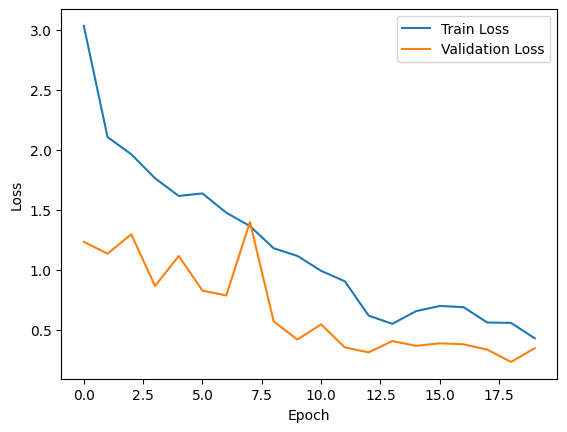

In [21]:
# Plot the training and validation losses
def plot_losses(train_losses, val_losses):
    """
    This function plots the training and validation losses over epochs.

    Parameters:
    train_losses (list): A list of training losses for each epoch.
    val_losses (list): A list of validation losses for each epoch.

    The function uses matplotlib to create a line plot of the training and validation losses. 
    The x-axis represents the epoch number and the y-axis represents the loss. 
    The training losses are plotted in one color and the validation losses are plotted in another color. 
    A legend is added to the plot to distinguish between the two lines. 
    Finally, the plot is displayed.
    """
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

if TRAIN:
    plot_losses(train_losses, val_losses)

## Test

In [23]:
# Load the best model
model = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [24]:
# Load and preprocess test data
test_file_paths = glob.glob('data/task1_2/test/*.npz')

test_dataset = ParticleDataset(test_file_paths, task, max_len, box_length, cutoff)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 100/100 [00:00<00:00, 176.29it/s]


In [25]:
print(f'Test dataset: {len(test_dataset)} samples')

Test dataset: 4000 samples


In [26]:
def compute_test_loss(model, test_loader, criterion):
    """
    This function computes the loss of the given model on the given test data using the given loss function.

    Parameters:
    model (torch.nn.Module): The model to test.
    test_loader (torch.utils.data.DataLoader): The data loader that provides the test data.
    criterion (torch.nn.Module): The loss function to use for testing.

    The function first sets the model to evaluation mode. Then, it iterates over the test data. 
    For each batch of data, it moves the data to the device, performs a forward pass, and computes the loss. 
    The function keeps track of the total loss over all batches. Finally, it returns the average loss over all batches.
    """
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(output, data.y.view(-1, 1))  # y is a single value per graph
            total_loss += loss.item()
    return total_loss / len(test_loader)

compute_test_loss(model, test_loader, criterion)

0.06291253622217129

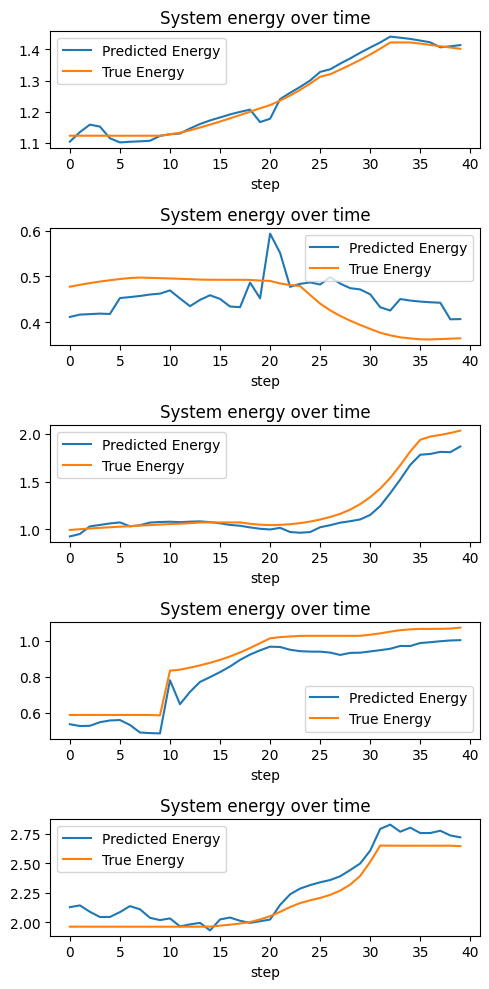

In [31]:
from torch_geometric.data import Batch

def plot_predictions(model, file_paths, device, task, num_plots=5, box_length=20.0, cutoff_value=10.0):
    """
    This function plots the predicted and true energies over time for a random selection of systems from the given file paths.

    Parameters:
    model (torch.nn.Module): The model to use for prediction.
    file_paths (list): A list of file paths to the system data.
    device (torch.device): The device to use for prediction.
    task (str): The task to perform (e.g., 'classification', 'regression').
    num_plots (int, optional): The number of plots to create. Default is 5.
    box_length (float, optional): The length of the box in which the particles are contained. Default is 20.0.
    cutoff_value (float, optional): The cutoff value for the interaction between particles. Default is 10.0.

    The function first sets the model to evaluation mode. Then, it selects a random subset of the file paths. 
    For each selected file path, it loads the system data, creates a graph from the system data, 
    and uses the model to predict the energies of the system over time. 
    It then plots the predicted energies and the true energies on the same plot. 
    The x-axis represents the time step and the y-axis represents the energy. 
    A legend is added to the plot to distinguish between the predicted and true energies. 
    Finally, the function displays all the plots.
    """
    model.eval()
    random_indices = np.random.randint(0, len(file_paths), size=num_plots)
    random_paths = [file_paths[i] for i in random_indices]

    fig, axs = plt.subplots(num_plots, 1, figsize=(5, num_plots*2))

    with torch.no_grad():
        plot_count = 0
        for i, path in enumerate(random_paths):
            
            trajectory, energy = load_trajectory(path, task)
           
            # Create a graph from the trajectory
            particles_list = create_particle_data_list(trajectory, energy, box_length, cutoff_value)
            batched_data = Batch.from_data_list(particles_list).to(device)

            output = model(batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.batch)

            # Plot predicted energies
            axs[plot_count].plot(output.cpu(), label='Predicted Energy')

            # Plot true energies
            axs[plot_count].plot(energy.flatten(), label='True Energy')

            axs[plot_count].set_xlabel('step')
            axs[plot_count].set_title('System energy over time')
            axs[plot_count].legend()

            
            plot_count += 1
            if plot_count == num_plots:
                break

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_file_paths, device, task)


## Tuning

In [28]:
import itertools

def grid_search(train_loader, val_loader, num_features, num_epochs, device, output_file):
    """
    This function performs a grid search over a set of hyperparameters to find the best model for the given training and validation data.

    Parameters:
    train_loader (torch.utils.data.DataLoader): The data loader that provides the training data.
    val_loader (torch.utils.data.DataLoader): The data loader that provides the validation data.
    num_features (int): The number of features in the input data.
    num_epochs (int): The number of epochs to train each model.
    device (torch.device): The device to use for training and validation.
    output_file (str): The path to the file where the grid search results will be written.

    The function iterates over all combinations of the hyperparameters. For each combination, it creates a model with the current hyperparameters, 
    trains the model for the given number of epochs, and computes the validation loss. 
    If the validation loss is lower than the best validation loss seen so far, the function updates the best model, best validation loss, and best hyperparameters. 
    The function writes the hyperparameters and validation loss of each model to the output file. 
    Finally, the function returns the best model, best hyperparameters, and best validation loss.
    """
    
    # Define hyperparameters to tune
    hidden_dims = [16, 32, 64]
    num_layers_list = [3, 5, 7]
    learning_rates = [0.0001, 0.001]
    weight_decays = [0.0, 1e-5]

    best_model = None
    best_val_loss = float('inf')
    best_params = {}

    with open(output_file, 'w') as f:
        f.write("hidden_dim,num_layers,lr,weight_decay,val_loss\n")

        for hidden_dim, num_layers, lr, weight_decay in tqdm(itertools.product(hidden_dims, num_layers_list, learning_rates, weight_decays)):
            # Create model with current hyperparameters
            model = MpGNN(num_features, hidden_dim=hidden_dim, num_layers=num_layers) # initialize our GNN
            # Define optimizer and criterion
            optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            criterion = torch.nn.MSELoss()

            best_model_loss = float('inf')

            # Train model
            print(f'Starting training with hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, weight_decay={weight_decay}')
            for epoch in range(num_epochs):
                train_loss = train(model, train_loader, optimizer,criterion, device)
                val_loss = validate(model, val_loader, criterion, device)
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {'hidden_dim': hidden_dim, 'num_layers': num_layers, 'lr': lr, 'weight_decay': weight_decay}
                    torch.save(best_model.state_dict(), 'best_model_grid_search.pth')

                if val_loss < best_model_loss:
                    best_model_loss = val_loss

            f.write(f"{hidden_dim},{num_layers},{lr},{weight_decay},{best_model_loss}\n")
            print(f"Finished training with hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, weight_decay={weight_decay}, val_loss={best_model_loss}")
     
    return best_model, best_params, best_val_loss


num_epochs = 20

if GRID_SEARCH:
    output_file = "grid_search_results.txt"
    best_model, best_params, best_val_loss = grid_search(train_loader, val_loader, num_features, num_epochs, device, output_file)
    torch.save(best_model.state_dict(), 'best_model_grid_search.pth')
    print("Best Parameters:")
    print(best_params)
    print("Best Validation Loss:", best_val_loss)

Best Parameters: {'hidden_dim': 64, 'num_layers': 7, 'lr': 0.0001, 'weight_decay': 0.0}

Best Validation Loss: 0.1772070269510299

# Task 2

Implement task 2 below. Feel free to add extra code cells for different components of your implementation.

# Task 3

In task 3, you also need to model the influences of the crystal. An example of loading a trajectory can be found below. The trajectory and energy data has the same shape as before, however, data regarding the crystal has been added. Since atoms belonging to the crystal do not move, this data does not have a time dimension when loaded. The shapes of the arrays are as follows:

```trajectory```: ```(time, n_bodies, [x, y, v_x, v_y, q])```

```energy```: ```(time, 1)```

```framework```:```(n_framework_atom, [x, y, q])```



In [29]:
trajectory, framework, energy = load_trajectory('data/task3/train/trajectory_0.npz', 'task_3')
print(f'Trajectory shape: {trajectory.shape}, Framework shape: {framework.shape}, Energy shape: {energy.shape}')

Trajectory shape: (40, 4, 5), Framework shape: (20, 3), Energy shape: (40, 1)


The following code provides an example of how to visualize a trajectory with a crystal. Feel free to modify this code, or write your own function. When evaluating your model in this task, keep in mind that you are only allowed to use the data at t=0 (the black dots in the visualization).

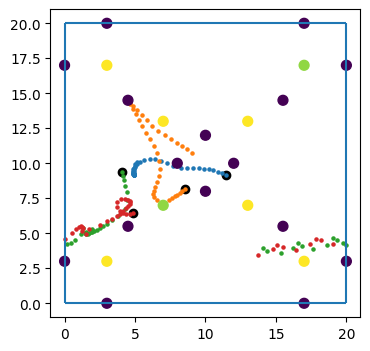

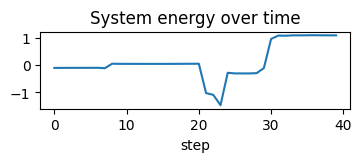

In [30]:
x = trajectory[...,0]
y = trajectory[...,1]

x_fw = framework[...,0]
y_fw = framework[...,1]
q_fw = framework[...,2]

plt.figure(figsize=(4,4))
plt.vlines([0,20],0,20)
plt.hlines([0,20],0,20)

plt.scatter(x[0], y[0], c='black')

for i in range(x.shape[1]):
    plt.scatter(x[:,i], y[:,i], s=5)

plt.scatter(x_fw, y_fw, c=q_fw, cmap='viridis', s=50)
# to also visualize the framework points along the boundaries
plt.scatter(x_fw+20, y_fw, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw, y_fw+20, c=q_fw, cmap='viridis', s=50)
plt.scatter(x_fw+20, y_fw+20, c=q_fw, cmap='viridis', s=50)

plt.xlim(-1,21)
plt.ylim(-1,21)

plt.show()
plt.figure(figsize=(4,1))
plt.plot(energy)
plt.xlabel('step')
plt.title('System energy over time')
plt.show();

Implement task 3 below. Feel free to add extra code cells for different components of your implementation.